In [47]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [48]:
df_m = pd.read_csv('../dataset/minority.csv')


In [64]:
# df = pd.read_csv('../dataset/majority_informative.csv')
# name = "informative_cluster"

df = pd.read_csv('../dataset/minority.csv')
name="min"


In [65]:
X = df.drop(columns=['isFraud'])
Y = df['isFraud'].values

In [66]:
df.columns

Index(['Unnamed: 0', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [67]:
# Separate numerical and categorical features
categorical_cols = ['type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]
X_original = X.copy()

# Scale numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

# Combine back into a DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=numerical_cols, index=X.index)
df_final = pd.concat([df_scaled, X[categorical_cols]], axis=1)

X_scaled = df_final


.Kmeans, Majority class, Informative samples

In [68]:
X_scaled.head()

,Unnamed: 0,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type
0,-1.967667,-0.610533,-0.464971,-0.097882,-0.163134,-0.32741,4
1,-1.967666,-0.610533,-0.464971,-0.097882,-0.156785,-0.32741,1
2,-1.967551,-0.609441,-0.464231,-0.097882,-0.163134,-0.32741,4
3,-1.967551,-0.609441,-0.464231,-0.097882,-0.155280,-0.32741,1
4,-1.967352,-0.602236,-0.459348,-0.097882,-0.163134,-0.32741,4


In [69]:
X_scaled.type.value_counts()

type
1    4116
4    4097
Name: count, dtype: int64

In [70]:
X.type.value_counts()

type
1    4116
4    4097
Name: count, dtype: int64

Silhouette Score = (b_i — a_i) / max(a_i, b_i)



GMMs Clustering
BIC balances model fit and complexity — it penalizes models with more parameters to avoid overfitting.
In clustering (like Gaussian Mixture Models), lower BIC values indicate better models

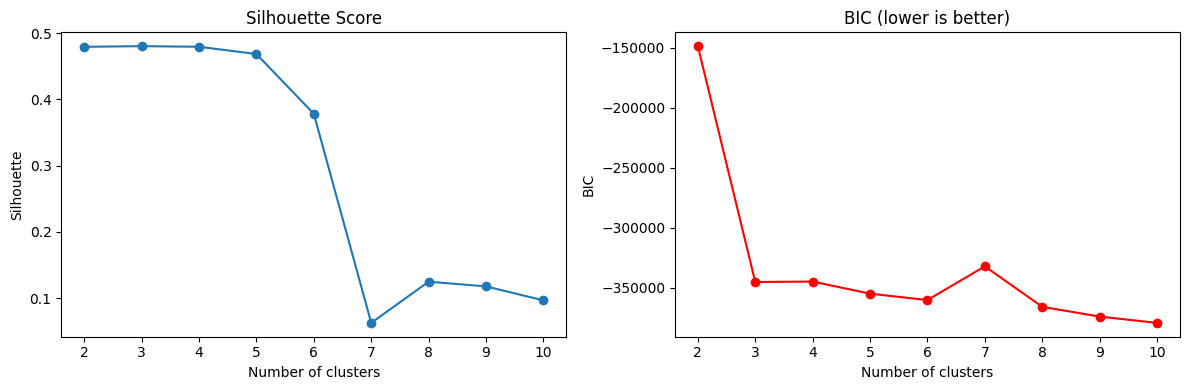

In [71]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Try different numbers of clusters (components)
n_components_range = range(2, 11)
sil_scores = []
bics = []

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    bic = gmm.bic(X_scaled)

    sil_scores.append(sil)
    bics.append(bic)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette")

plt.subplot(1, 2, 2)
plt.plot(n_components_range, bics, marker='o', color='red')
plt.title("BIC (lower is better)")
plt.xlabel("Number of clusters")
plt.ylabel("BIC")

plt.tight_layout()
plt.show()


In [72]:
best_k = n_components_range[sil_scores.index(max(sil_scores))]
print(f"Best number of clusters (k): {best_k}")


Best number of clusters (k): 3


Based on Silhouette and BIC, Best number of clusters is 3, with Silhouette score = 0.3, meaning that there is some overlapping

In [73]:
gmm = GaussianMixture(n_components=best_k, random_state=42)
labels = gmm.fit_predict(X_scaled)
probs = gmm.predict_proba(X_scaled)  # optional: soft assignments


In [74]:
X_original_with_clusters = X_original.copy()
X_original_with_clusters['cluster'] = labels

In [75]:
# Save all clusters in one CSV
X_original_with_clusters.to_csv("../dataset/original_data_with_clusters.csv", index=False)

# Optionally save each cluster separately
import os
os.makedirs("clusters", exist_ok=True)

for cluster_id in sorted(X_original_with_clusters['cluster'].unique()):
    cluster_df = X_original_with_clusters[X_original_with_clusters['cluster'] == cluster_id]
    cluster_df = cluster_df.drop(columns=['cluster'])
    cluster_df.to_csv(f"../dataset/{name}_{cluster_id}.csv", index=False)


I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
I:\ETVOS\2nd semester\DS Lab 1\DSLAB-Project\venv1\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


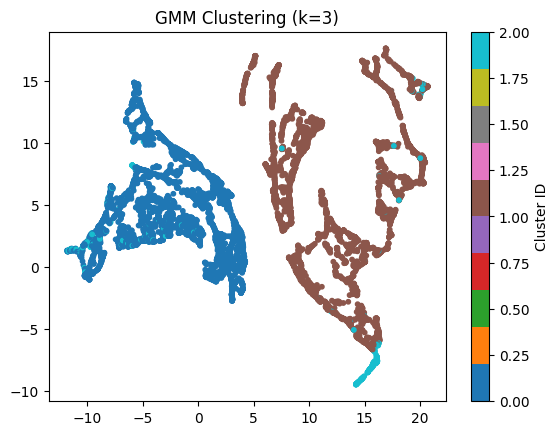

In [76]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10)
plt.title(f"GMM Clustering (k={best_k})")
plt.colorbar(label="Cluster ID")
plt.show()


In [77]:
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# Add cluster labels and the target (is_fraud = 0 for majority class)
X_df['cluster'] = labels
# X_df['is_fraud'] = Y  # 0s for majority class

In [78]:
df_m_0 = "min_0"
df_m_1 = "min_1"
df_m_2 = 'min_2'
df_0 = 'informative_cluster_0'
df_1 = 'informative_cluster_1'
files = [df_m_0, df_m_1, df_m_2, df_0, df_1]

for name in files:
    pd.read_csv(f"../dataset/{name}.csv").drop(columns=["Unnamed: 0"], errors="ignore").assign(
    isFraud=1 if "min" in name else 0).to_csv(f"../dataset/{name}_labeled.csv", index=False)

In [79]:
df_m = "df_min"
df_majority = "df_majority"
files = [df_m, df_majority,]

for name in files:
    pd.read_csv(f"../dataset/{name}.csv").drop(columns=["Unnamed: 0"], errors="ignore").assign(
    isFraud=1 if "min" in name else 0).to_csv(f"../dataset/{name}_labeled.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/df_min.csv'